### Google calendar como tool

Instalar la librería de Google Client

In [13]:
#se instala usando poetry
#poetry install google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [14]:
#import básicas
import datetime
import os
import io  # Para manejo de JSON

In [15]:
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# Scope para acceso de lectura/escritura en Calendar
SCOPES = ['https://www.googleapis.com/auth/calendar']

def auth_google_calendar():
    creds = None
    token_google = 'token_google'  
    credentials_file = '../credentials.json'  
    
    # Verifica si el archivo de token existe y es válido
    if os.path.exists(token_google):
        try:
            creds = Credentials.from_authorized_user_file(token_google, SCOPES)
            print("Token cargado correctamente")
        except ValueError as e:
            print(f"Error en el token: {e}. Borrando y regenerando...")
            os.remove(token_google)  # Borra automáticamente el archivo malo
            creds = None  # Fuerza reautorización
    
    # Si no hay credenciales válidas, autoriza
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            if not os.path.exists(credentials_file):
                print(f"Error: No se encuentra {credentials_file}. Descárgalo de Google Cloud Console.")
                return
            flow = InstalledAppFlow.from_client_secrets_file(credentials_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Guarda las credenciales para la próxima vez
        with open(token_google, 'w') as token:
            token.write(creds.to_json())
        print(f"Token guardado en {token_google}.")
    return build('calendar','v3',credentials=creds)


In [16]:
def new_event(service, **kwargs):    
        
    # Configura el evento básico
    event = {
        'summary': kwargs.get('summary','TEST Reunión de Prueba con IA'),
        'location': 'Oficina',
        'description': kwargs.get('description', 'Evento creado con Python y Google Calendar API'),
        'start': {
            'dateTime': kwargs.get('date','2025-09-30T10:00:00-05:00'),  # Mañana a las 10 AM (ajusta)
            'timeZone': 'America/Guayaquil',  # Timezone Ecuador
        },
        'end': {
            'dateTime': kwargs.get('date','2025-09-30T10:00:00-05:00'),
            'timeZone': 'America/Guayaquil',
        },
        'attendees': [
            {'email': 'tu-email@ejemplo.com'},  # Agrega emails reales
        ],
        'reminders': {
            'useDefault': False,
            'overrides': [
                {'method': 'email', 'minutes': 24 * 60},  # Email 1 día antes
                {'method': 'popup', 'minutes': 10},       # Popup 10 min antes
            ],
        },
    }
        
    try:
        # Crea el evento en el calendario principal
        event = service.events().insert(calendarId='primary', body=event).execute()
        print(f'Evento creado exitosamente: {event.get("htmlLink")}')
        return event
        
    except HttpError as error:
        print(f'Error al crear el evento: {error}')
        return None

In [17]:
# tool crear evento
from typing_extensions import TypedDict

class EventInput(TypedDict):
    summary: str
    current_date: str
    current_time: str | None

def create_event(event: EventInput) -> str:
    """
    tool: agenda citas en google calendar, determina la fecha exacta que te pide el usuario 

    """
    service = auth_google_calendar()
    if service:
        date_event=event["current_date"] + "T" + event["current_time"] + ":00" + '-05:00'
        new_event(service,summary=event["summary"],date=date_event,time=event["current_time"])
        
        return "evento creado correctamente"


In [18]:
# tool fecha actual
from datetime import datetime, date

class CurrentInput(TypedDict):
    summary: str
    current_date: str
    current_time: str | None

def current_date_time(event: EventInput) -> EventInput:
    """
    Tool: cuando el usuario hable de tiempo usa esta herramienta para determinar la fecha actual,
    realiza las operaciones necesarias para cumplir con la fecha que pide el usuario
    """
    today = date.today().isoformat()
    # current_time = datetime.now().isoformat()
    return {"current_date":today, "current_time": event["current_time"], "summary": event["summary"]}

In [19]:
#tool consultar eventos
from typing_extensions import TypedDict

class GetEvent(TypedDict):
    date: str

def get_events(getevent: GetEvent) -> str:
    """
    tool: consulta las citas en google calendar, 
    pasa la fecha que esta requiriendo el usuario

    """
    service = auth_google_calendar()
    if service:
        time_min = getevent["date"] + "T01:00:00Z"
        time_max = getevent["date"] + "T23:00:00Z"

        events_result = service.events().list(
        calendarId="primary",  
        timeMin=time_min,
        timeMax=time_max,
        singleEvents=True,
        orderBy="startTime"
        ).execute()

    events = events_result.get("items", [])

    if not events:
        return "No hay eventos en este día."
    else:
        lista_eventos=[]
        for event in events:
            start = event["start"].get("dateTime", event["start"].get("date"))
            lista_eventos.append(f"- {event['summary']} a las {start}")
        return lista_eventos

In [20]:
#tool suma
def tool_add(a: int, b:int) -> int:
    """suma a y b
    
    Args: 
        a (int): primero
        b (int): segundo  

    Returns:
        int: la suma de a y b

    """
    return a + b

In [21]:
# event_request = {"date": "2025-09-21"}
# print(get_events(event_request))


In [22]:
#call tools
from langchain_openai import ChatOpenAI
tools = [current_date_time,create_event, get_events, tool_add]
llm=ChatOpenAI(model="gpt-4o-mini")
# llm_with_tools = llm.bind_tools(tools)
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [23]:
#prompt
from langchain_core.messages import SystemMessage, HumanMessage
system_msg = SystemMessage(content="eres un asistente útil cuya tarea es identificar fechas del usuario")

In [24]:
#
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [25]:
#node
def assistant(state: State) -> State:
    return {"messages": [llm_with_tools.invoke([system_msg] + state["messages"])]}

In [26]:
#langraph
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

#Graph
builder = StateGraph(State)

#nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#Define edge (secuencia)
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")

#Compile
graph=builder.compile()

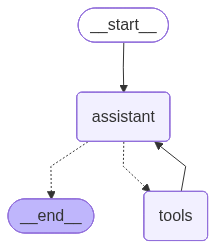

In [27]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### Memoria
Se necesita especificar el thread_id, este será el encargado de almacenar los estados del graph de la colección 

In [28]:
# configurando memoria 
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [29]:
# especificar un thread
config = {"configurable": {"thread_id": "1"}}

#### Mensajes

In [30]:
messages = [HumanMessage(content="suma a eso mas 4")]
messages = graph.invoke({"messages": messages},config)

In [31]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

suma a eso mas 4
================================== Ai Message ==================================
Tool Calls:
  tool_add (call_TsO6i5GSziaDQ7lt2wd8ChWo)
 Call ID: call_TsO6i5GSziaDQ7lt2wd8ChWo
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: tool_add

7
================================== Ai Message ==================================

La suma de 3 más 4 es 7.


In [32]:
messages

{'messages': [HumanMessage(content='suma a eso mas 4', additional_kwargs={}, response_metadata={}, id='14fa7feb-5d19-46f0-88e4-92007e4ad340'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TsO6i5GSziaDQ7lt2wd8ChWo', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'tool_add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 222, 'total_tokens': 240, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CSOpTFcnCtgmqk1mnnJhq2lYjDBpz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--63f07819-f276-457d-9ef9-c5d7c312d38d-0', tool_calls=[{'name': 'tool_add', 'args': {'a': 3, 'b': 4}, 'id': 'call_TsO6i5GSziaDQ7lt2wd8C